In [2]:
"""Define the variable 'directory' if not working in the current directory.
    By default, it is set to the current working directory.
    
    This module has two main functions, flux_stat() and test_joe_code()"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

from scipy.stats import chi2
from matplotlib.pyplot import *
from scipy.optimize import curve_fit

import sys
import pylab
import os

In [3]:
directory = os.getcwd()+'/data/'

In [4]:
def joe_code(flux,plot=False,hst_bin=15,stts=True):
    
    """Takes input arrays for flux
        plot to show built-in histograms and pdfs"""
    
    # Model function:
    def func_cdf(x, a, b, k):
        return a*chi2.cdf(b*x,k)

    def func_pdf(x, a, b, k):
        return a*chi2.pdf(b*x,k)

    k = 2
    ktest = True
    nflux = len(flux)

    # Compute basic stats
    avg_flux = np.mean(flux)
    med_flux = np.median(flux)
    std_flux = np.std(flux)
    mod_index = np.std(flux)/avg_flux
    DOF      = int(np.round(2.0/mod_index**2))    # E.g., see wikipedia page.

    # “k” is just the degrees of freedom parameter. If unsure, can just start with 2 and calculate on the fly.
    if ktest:
        test_diff = np.abs(k-DOF)

        if test_diff > 0:
#             print 'k value has been changed: '+str(k)+' --> '+str(DOF)
#             print 'DOF'+DOF
            k = DOF

    # CDF (“cumulative distribution function”)
    sort_flux = np.sort(flux)
    sort_fpa  = sort_flux/avg_flux
    sort_fpm  = sort_flux/med_flux
    cdf = np.arange(nflux)/float(nflux)

    # Do the fit
    data = sort_fpa
    div_str = str(avg_flux)[0:4]

    n_x_bin = 300
    x = np.linspace(min(data),max(data),n_x_bin)

    # Fits for “a” and “b” parameters.
    popt,pcov = curve_fit(lambda x, a, b: func_cdf(x,a,b,k),data,cdf,[1.0,float(DOF)])

    a_text = 'a = '+str(popt[0])[0:4]
    b_text = 'b = '+str(popt[1])[0:4]
    k_text = 'k = '+str(k)
    
    if stts:
        print 'DOF ',DOF
        print a_text
        print b_text
   
    chi2_pdf = func_pdf(x,popt[0],popt[1],k)
        
#     global df, chi2_name, x_range
#     df, chi2_name, x_range = DOF, chi2_pdf, x
    global chi2_name
    chi2_name = chi2_pdf
    
    
#     Conditional. Plot the results:    
    if plot:
        n_hist_bin = hst_bin
        n,bins,rects = plt.hist(data,n_hist_bin,color='black',histtype='bar',rwidth=0.8,normed=True)

        amp_mult = (np.sum(n)/np.sum(chi2_pdf))*n_x_bin/n_hist_bin
        plt.plot(x,amp_mult*chi2_pdf,c='red',ls='--',lw=2)
        
        plt.show()
        
            
#write flux data to a text file
def txt(pulsar_name,high_limit):
    """Takes a global variable defined in the stats function and writes the flux data
        to a file called 1234+5687_hi/lo or pulsar_name_hi and pulsar_name_lo"""
    
    flux_stats(pulsar_name,high_limit,scatter=False,hist=False,stats=False)
    
    f = open(directory+pulsar_name+"_lo",'w')
    # tx_lo=lo_freq_flux; global variable defined in flux_stat 
    for x in tx_lo:
        f.write(str(x)+'\n')
    f.close()

    f = open(directory+pulsar_name+"_hi",'w')
    # tx_hi=hi_freq_flux; global variable defined in flux_stat 
    for x in tx_hi:
        f.write(str(x)+'\n')
    f.close()
    
# Import data as 'hi' and 'lo' arrays
def pull(pulsar_name,prnt=False,rng=4):
    """Pulls flux data from 1234+5678_hi/lo or pulsar_name_hi 
        and pulsar_name_lo files and creates arrays called 'lo' and 'hi'.
        
        rng=# set a range for prnt
        prnt=True will print a range of fluxes from the arrays, the default is 4
        
        """
    global lo
    lo =[]
    f = open(directory+pulsar_name+'_lo','r')
    for x in f:
        y = float((x.split('\n'))[0])
        lo.append(y)
    f.close()
    if prnt:
        print (lo[:rng]),'\n'

    global hi
    hi =[]
    f = open(directory+pulsar_name+'_hi','r')
    for x in f:
        y = float((x.split('\n'))[0])
        hi.append(y)
    f.close()
    if prnt:
        print (hi[:rng]),'\n'

        
def test_joe_code(pulsar_name,high_limit,rang=4,plot=True,prnt=False,wrt=False,stats=True):
    """Function for testing the pdf for a given pulsar without having to call
        and troubleshoot the flux_stat function.
        pull() function is called by default to build arrays of fluxes
        prnt=boolean, print a range of flux values from the txt file arrays
        wrt=boolean, writes the flux arrays to txt files using txt() function, use if files don't exist
        """
    if wrt:
        txt(pulsar_name,high_limit)
    pull(pulsar_name,prnt,rng=rang)
    s = [lo,hi]
    for b in s:
        joe_code(b,plot,stts=stats)

In [5]:
def flux_stats(pulsar_name,high_limit,scatter=True,hist=True,PDF=True,CDF=True,stats=True,xrg=True,xrgmax=20,xrgmin=0,bins=50,joe_plot=False):
    
    """Generate statistics and plots for a given pulsar. High_limit implies a way to filter outliers.
        scatter,hist,PDF,CDF, are all boolean, and by default are instantiated to plot various graphics of the pulsar statistics.
        pulsar_name=string '1234+5678'
        high_limit=# to filter outliers
        xrg=boolean, set True for default x axis range on histogram, False to customize with xrgmax/min
        
        """
    low_limit = 0.001 
    
    # load dictionary created in Flux Database Builder notebook
    pulsar_dict = pickle.load(file(directory+pulsar_name))
    """ {"Name":"Mean Flux","Subint Fluxes","Freq","MJD",
        "Subint","Chan", "Bin","Polarity","Period","Year"}
    """
    # print len(pulsar_dict)
    
    
    # Temporary lists to parse data from the dictionary, defined below
    ch = []
    subint_stats = []

    for key in pulsar_dict:
        mjd = pulsar_dict[key][3]
        freq = pulsar_dict[key][2]
        mean_flux = pulsar_dict[key][0]
        filename = key
        bh =[]
        print freq
        
        # ch is a temp list to create a single dictionary entry per sub int flux
        for u in pulsar_dict[key][1]:
            # strip brackets from flux values for sub int fluxes
            sub_int_flux_i = u[0][0][0]
            ch.append([sub_int_flux_i, freq, mjd, mean_flux, filename])
            # check if sub int fluxes exceed limits
            if sub_int_flux_i < low_limit:
                continue
            if sub_int_flux_i > high_limit:
                continue
            if mjd < 50000:
                continue
            # bh is a temp list of sub int fluxes per pulsar_dict[key]
            bh.append(sub_int_flux_i)
        if len(bh) > 0:
            # subint_stats is an array that stores calculated stats on sub int fluxes per entry
            mean_flx = np.mean(bh)
            sub_int_std_dev = np.std(bh)
            sub_int_min = np.min(bh)
            sub_int_max = np.max(bh)
            subint_stats.append([mean_flx, freq, mjd, filename, sub_int_std_dev, sub_int_min, sub_int_max])
            # a few discrepancies in the mean, using the given mean (from other notebook) here for now
    #         if mean_flx != mean_flux:
    #             print (key)          
    #             print (mean_flux, mean_flx), '\n'

    # print (len(ch)) # should be large, using sub int fluxes        
    # print (len(subint_stats))
    # Temp list of all mjd values
    mjd_both_freqs = []    

    # lists of sub int fluxes sorted by frequency
    high_freq_flux=[]
    low_freq_flux=[]

    # lists of calculated mean fluxes sorted by frequency
    hi_fr_mean=[]
    lo_fr_mean=[]

    # ch is similar to pulsar_dict, but with one sub int per entry
    """{ ch[item] = sub_int_flux_i, freq, mjd, mean_flux, filename }"""
    for item in ch:
        # check if the given mean flux exceeds the limits set above
        if item[0] < low_limit:
            continue
        if item[0] > high_limit:
            continue
        # Sort each item by frequency, create arrays for sub int & mean fluxes
        if item[1] > 1400: # 1500 MHz
            high_freq_flux.append(item[0])
            hi_fr_mean.append(item[3])
        if item[1] < 1400: # 820 MHz
            low_freq_flux.append(item[0])
            lo_fr_mean.append(item[3])
        # Collect all mjds for parsing later
        mjd_both_freqs.append(item[2])

    # Eliminate duplicates in the mean-flux arrays
    lo_fr_mean = (set(lo_fr_mean))
    hi_fr_mean = (set(hi_fr_mean))

    # mjd_both_freqs length: n pulsar_dict entries times n sub int fluxes
    # print (len(mjd_both_freqs))
    # print len(lo_fr_mean), len(hi_fr_mean)
    # print (len(high_freq_flux), len(low_freq_flux))
    
    """ subint_stats[item] = mean_flux, freq, mjd, filename, 
                        sub_int_std_dev, sub_int_min, sub_int_max
"""

    # lists of entries in subint_stats, sorted by frequency
    hi_fr_sub_stat = []
    lo_fr_sub_stat = []

    # Sort subint_stats by freq & build separate arrays with each item an array, used for scatter plot
    for item in subint_stats:
    #     if item[5] < low_limit:
    #         continue
    #     if item[6] > high_limit:
    #         continue
    #     if item[0] > high_limit:
    #         continue
    #     if item[0] < low_limit:
    #         continue
        if item[1] > 1400:
            hi_fr_sub_stat.append(item)
        if item[1] < 1400:
            lo_fr_sub_stat.append(item)

    # print MJD range
    mjd_min = np.min(mjd_both_freqs)
    mjd_max = np.max(mjd_both_freqs)
#     print 'MJD min/max\n', mjd_min, mjd_max, '\n'

    # (Filter out any 'Not a Number' values)
    lo_freq = [x for x in low_freq_flux if str(x) != 'nan'] # 820 MHz 
    hi_freq = [y for y in high_freq_flux if str(y) != 'nan'] # 1500 MHz 

    # arrays of high and low freq sorted sub-int flux values
    lo_freq_flux = np.sort(lo_freq)
    hi_freq_flux = np.sort(hi_freq)
    
    # for writing to a txt file
    global tx_lo,tx_hi
    tx_lo,tx_hi = lo_freq_flux,hi_freq_flux
    
    # print (len(lo_freq_flux), len(hi_freq_flux))

    # Build a library of statistics
    # Stats for 820 MHz
   
    mu_lo, sigma_lo, min_lo, max_lo, len_lo = (np.mean(lo_freq_flux),np.std(lo_freq_flux),np.min(lo_freq_flux),np.max(lo_freq_flux),len(lo_freq_flux))
    mu_hi, sigma_hi, min_hi, max_hi, len_hi = (np.mean(hi_freq_flux),np.std(hi_freq_flux),np.min(hi_freq_flux),np.max(hi_freq_flux),len(hi_freq_flux)) 
        
        
    
    if stats:
        print 'MJD min/max\n', mjd_min, mjd_max, '\n'
        
        print 'Mean, Std, Min, Max, length for 820 MHz list'
        print mu_lo, sigma_lo, min_lo, max_lo, len_lo

        #Stats for 1500 MHz
    #     mu_hi, sigma_hi, min_hi, max_hi, len_hi = (np.mean(hi_freq_flux),np.std(hi_freq_flux),np.min(hi_freq_flux),np.max(hi_freq_flux),len(hi_freq_flux)) 
        print '\nMean, Std, Min, Max, length for 1500 MHz list'
        print mu_hi, sigma_hi, min_hi, max_hi, len_hi, '\n'
    
    
    """ lo/hi_fr_sub_stat[item] = mean_flux, freq, mjd, filename, 
                        sub_int_std_dev, sub_int_min, sub_int_max
"""

    if scatter:

        ### Plot a scatter of the flux values of MJD
        ### Plot with the mean flux values and errorbars

        for item in lo_fr_sub_stat:
            # MJD value
            x_lo = item[2]
            # fully scrunched flux (mean)
            y_lo = item[0]
            # item[4,5,6] = item[std,min,max]    
            std_lo = item[4]
            mn_lo = item[5] 
            mx_lo = item[6]
            # plot low freq fluxes
            lo_sctr = plt.scatter(x_lo,y_lo,marker="+",color="red",linewidth=1,label = '820 MHz')
            c = [mn_lo, mx_lo]
            # plot low freq flux errors
            plt.errorbar(x_lo,y_lo,yerr=std_lo,linewidth=1,color='crimson',alpha = .8) 

        for item in hi_fr_sub_stat:
            # MJD Value
            x_hi = item[2]
            # fully scrunched flux (mean)
            y_hi = item[0] 
            # item[4,5,6] = item[std,min,max]
            std_hi = item[4] 
            mn_hi = item[5]
            mx_hi = item[6]
            # plot high freq fluxes
            hi_sctr = plt.scatter(x_hi,y_hi,marker="+",color="steelblue",linewidth=1,label = '1500 MHz')
            # plot high freq flux errors
            plt.errorbar(x_hi,y_hi,yerr=std_hi,linewidth=1,color='royalblue',alpha=.8)

        ### plot mean flux lines
        mu_line_lo = plt.axhline(y=mu_lo, color='crimson', linestyle='--',linewidth=1.5,label='820 MHz Mean')
        # dv = plt.axhline(y=sigma+mu, color='brown', linestyle='--',linewidth=1.5)
        mu_line_hi = plt.axhline(y=mu_hi, color='b', linestyle='--',linewidth=1.5,label='1500 MHz Mean')
        # fv = plt.axhline(y=sigma_2+mu_2, color='royalblue', linestyle='--',linewidth=1.5)

        ### Std dev vertical ranges 
        rg_mn_lo = mu_lo - sigma_lo
        rg_mx_lo = mu_lo + sigma_lo
        rg_mn_hi = mu_hi - sigma_hi
        rg_mx_hi = mu_hi + sigma_hi

        ### plot standard deviation to the mean
        plt.axhspan(rg_mn_lo, rg_mx_lo, alpha=0.2, color='red')
        plt.axhspan(rg_mn_hi, rg_mx_hi, alpha=0.3, color='steelblue')

        if xrg:
            xmin, xmax = xlim()
            plt.xlim()
#             xgmax = max_lo
#             plt.xlim(0,xgmax)
        # defined in the function, must set xrg=False to acivate limits, otherwise xlim is default
        else:
            plt.xlim(xrgmin,xrgmax)
        plt.legend((lo_sctr,hi_sctr,mu_line_lo,mu_line_hi),('820 MHz','1500 MHz','820 MHz Mean Flux', '1500 MHz Mean Flux'),ncol=2,loc='upper right', prop={'size': 6})#,fontsize = 4)
        plt.grid(True)
        plt.xlabel('MJD')
        plt.ylabel('Flux (mJy)')
        plt.grid(linestyle='dotted')
        plt.title(pulsar_name)
        plt.show()

        import matplotlib as mpl
        mpl.rcParams['savefig.dpi'] = 300
        mpl.rcParams['figure.dpi'] = 300
        plt.rcParams['figure.facecolor'] = 'white'
        matplotlib.pyplot.close('all')
    
    if hist:
        # initiate histogram plotting sequence
        joe_code(lo_freq_flux,joe_plot,stts=stats)
        chi2_lo = chi2_name

        
        joe_code(hi_freq_flux,joe_plot,stts=stats)
        chi2_hi = chi2_name


        n_x_bins = 300
        x_lo = np.linspace(min_lo,max_lo,n_x_bins)
        x_hi = np.linspace(min_hi,max_hi,n_x_bins)

        
        fig, ax = plt.subplots()
        n_hist_bins = bins
        n, binz, patches = ax.hist(lo_freq_flux,n_hist_bins,normed=1,align='mid',histtype='stepfilled',alpha=.8,rwidth=.9,color='red',edgecolor='none',label='820 MHz Flux Density')#, orientation = 'horizontal')
        nn, binn, patchesn = ax.hist(hi_freq_flux,n_hist_bins,normed=1,align='mid',histtype='stepfilled',alpha=.8,rwidth=.9,edgecolor='none',label='1500 MHz Flux Density')# ,orientation = 'horizontal')
          
        if PDF:
            
            amp_mult_lo = (np.sum(n)/np.sum(chi2_lo))*n_x_bins/n_hist_bins
            amp_mult_hi = (np.sum(nn)/np.sum(chi2_hi))*n_x_bins/n_hist_bins

            plt.plot(x_lo,amp_mult_lo*chi2_lo,'r--',lw=1.4, alpha=0.8, label='chi2 pdf 820')
            plt.plot(x_hi,amp_mult_hi*chi2_hi,'b--',lw=1.4, alpha=0.8, label='chi2 pdf 1500')
        
        if xrg:
#             xmin, xmax = xlim()
#             plt.xlim()
            xgmax = max_lo
            plt.xlim(0,xgmax)
        # defined in the function, must set xrg=False to acivate
        else:
            plt.xlim(xrgmin,xrgmax)
        plt.legend(prop={'size': 6})
        plt.grid(True)
        plt.ylabel('Density')
        plt.xlabel('Flux (mJy)')
        plt.grid(linestyle='dotted')
        plt.title(pulsar_name)
        plt.show()

        import matplotlib as mpl
        mpl.rcParams['savefig.dpi'] = 300
        mpl.rcParams['figure.dpi'] = 300
        plt.rcParams['figure.facecolor'] = 'white'
        matplotlib.pyplot.close('all')
        


In [18]:
# """ click on a name and press ('Cmd' + '/') to easily turn on/off a pulsar name"""

# pulsar_name, high_limit = '0613-0200', 100
# pulsar_name, high_limit = '2145-0750', 40 
# pulsar_name, high_limit = '1600-3053', 20
# pulsar_name, high_limit = '1012+5307', 30
# pulsar_name, high_limit = '1643-1224', 50
# pulsar_name, high_limit = '1909-3744', 10
# pulsar_name, high_limit = '2010-1323', 5
# pulsar_name, high_limit = '1744-1134', 50
# pulsar_name, high_limit = '1024-0719', 17.5
# pulsar_name, high_limit = '1713+0747', 65

# flux_stats(pulsar_name,high_limit,scatter=False)

In [19]:
# flux_stats(pulsar_name,high_limit,scatter=False,xrg=True,stats=True,joe_plot=True,hist=True)
# flux_stats(pulsar_name,high_limit,scatter=False,xrg=False,xrgmin=5,xrgmax=12,stats=False)
# flux_stats(pulsar_name,high_limit,scatter=False,xrg=False,xrgmin=8.4,xrgmax=8.6,stats=False)
# flux_stats(pulsar_name,high_limit,scatter=True,xrg=True,xrgmin=56350,xrgmax=56450,stats=False,hist=False)
# flux_stats(pulsar_name,high_limit,scatter=True,xrg=False,xrgmin=56350,xrgmax=56450,stats=False,hist=False)

# test_joe_code(pulsar_name,high_limit,wrt=True)

1499.21875
820.78125
820.78125
1499.21875
808.28125
1499.21875
1499.21875
820.78125
820.78125
1499.21875
820.78125
1499.21875
1499.21875
820.78125
1499.21875
1499.21875
820.78125
1499.21875
820.78125
820.78125
1499.21875
1499.21875
820.78125
820.78125
820.78125
820.78125
1499.21875
1499.21875
820.78125
1499.21875
820.78125
1499.21875
820.78125
1499.21875
1499.21875
1499.21875
1499.21875
1499.21875
820.78125
820.78125
1499.21875
1499.21875
1499.21875
820.78125
820.78125
820.78125
820.78125
820.78125
820.78125
1499.21875
820.78125
1499.21875
1499.21875
820.78125
1499.21875
1499.21875
820.78125
820.78125
1499.21875
820.78125
1499.21875
820.78125
820.78125
820.78125
820.78125
1499.21875
811.852678571
820.78125
1499.21875
820.78125
820.78125
1499.21875
1499.21875
1499.21875
1499.21875
820.78125
1499.21875
1499.21875
808.28125
1499.21875
1499.21875
1499.21875
820.78125
1499.21875
1499.21875
820.78125
1499.21875
1499.21875
1499.21875
820.78125
1499.21875
820.78125
1499.21875
1499.21875
820.78

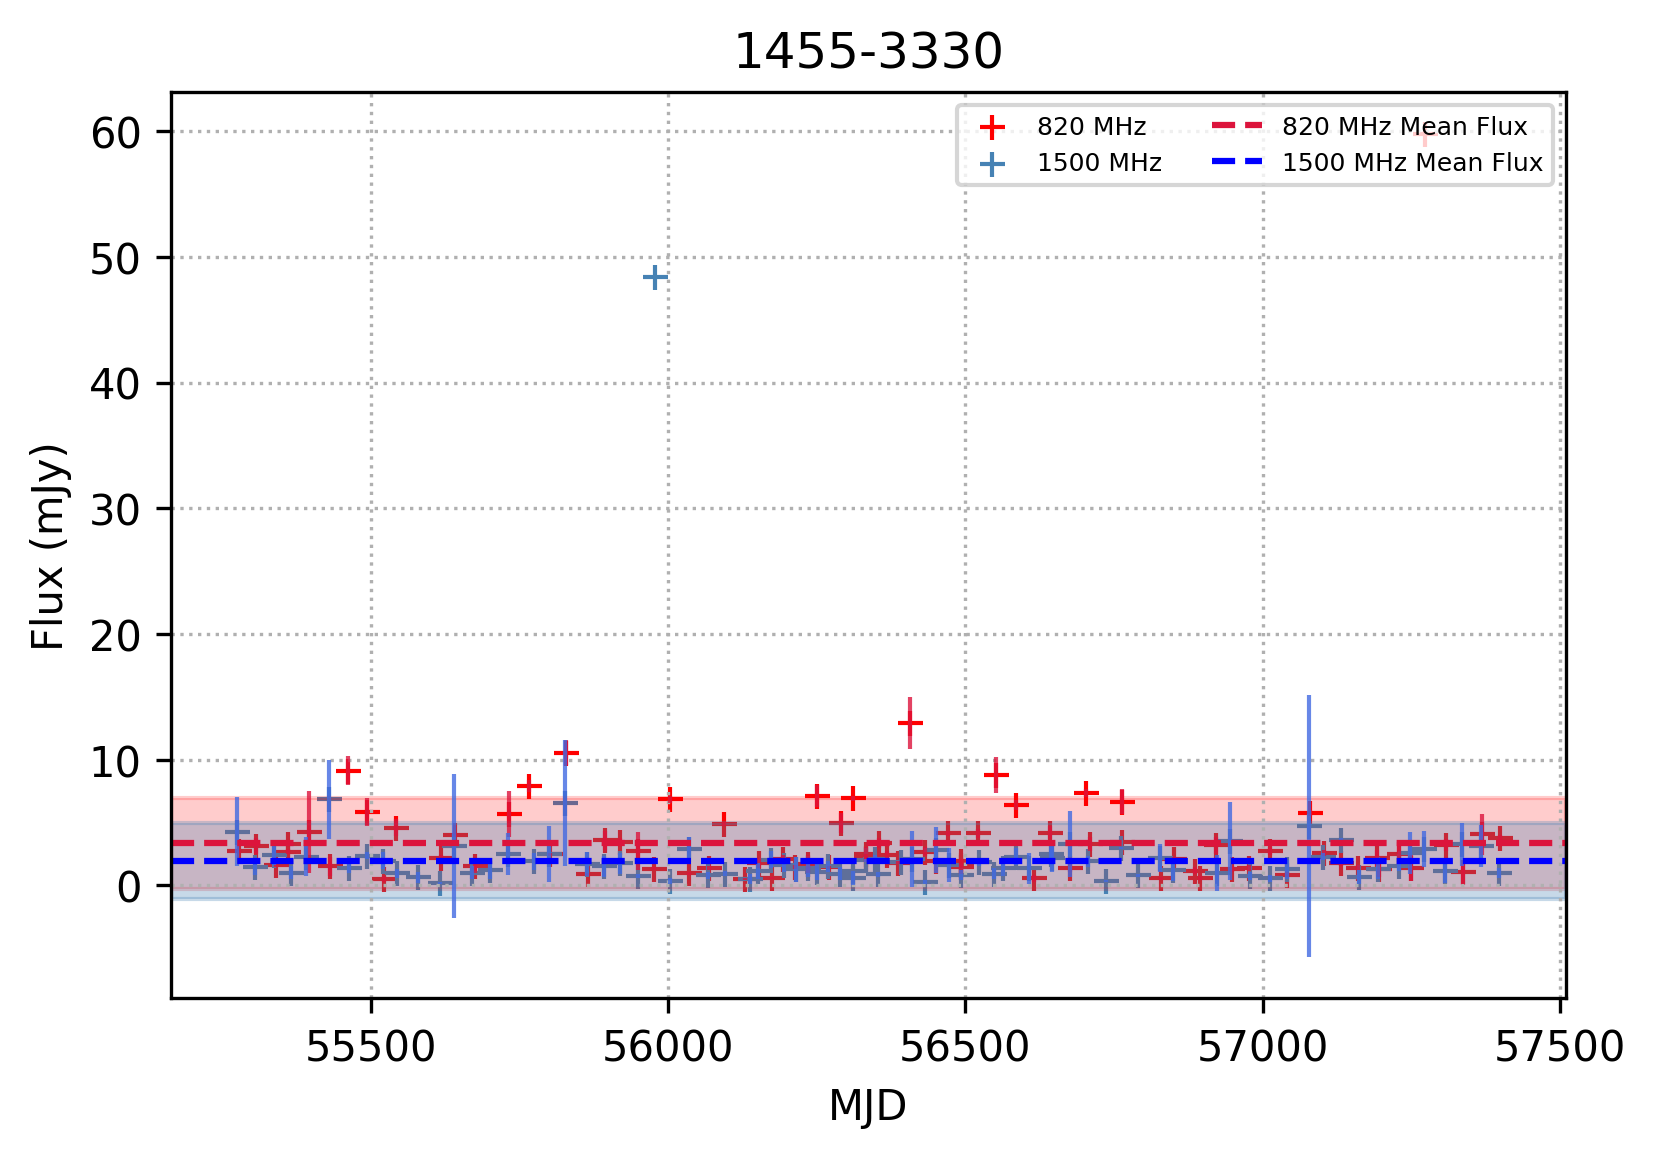

DOF  2
a = 1.13
b = 1.50
DOF  1
a = 1.33
b = 0.36


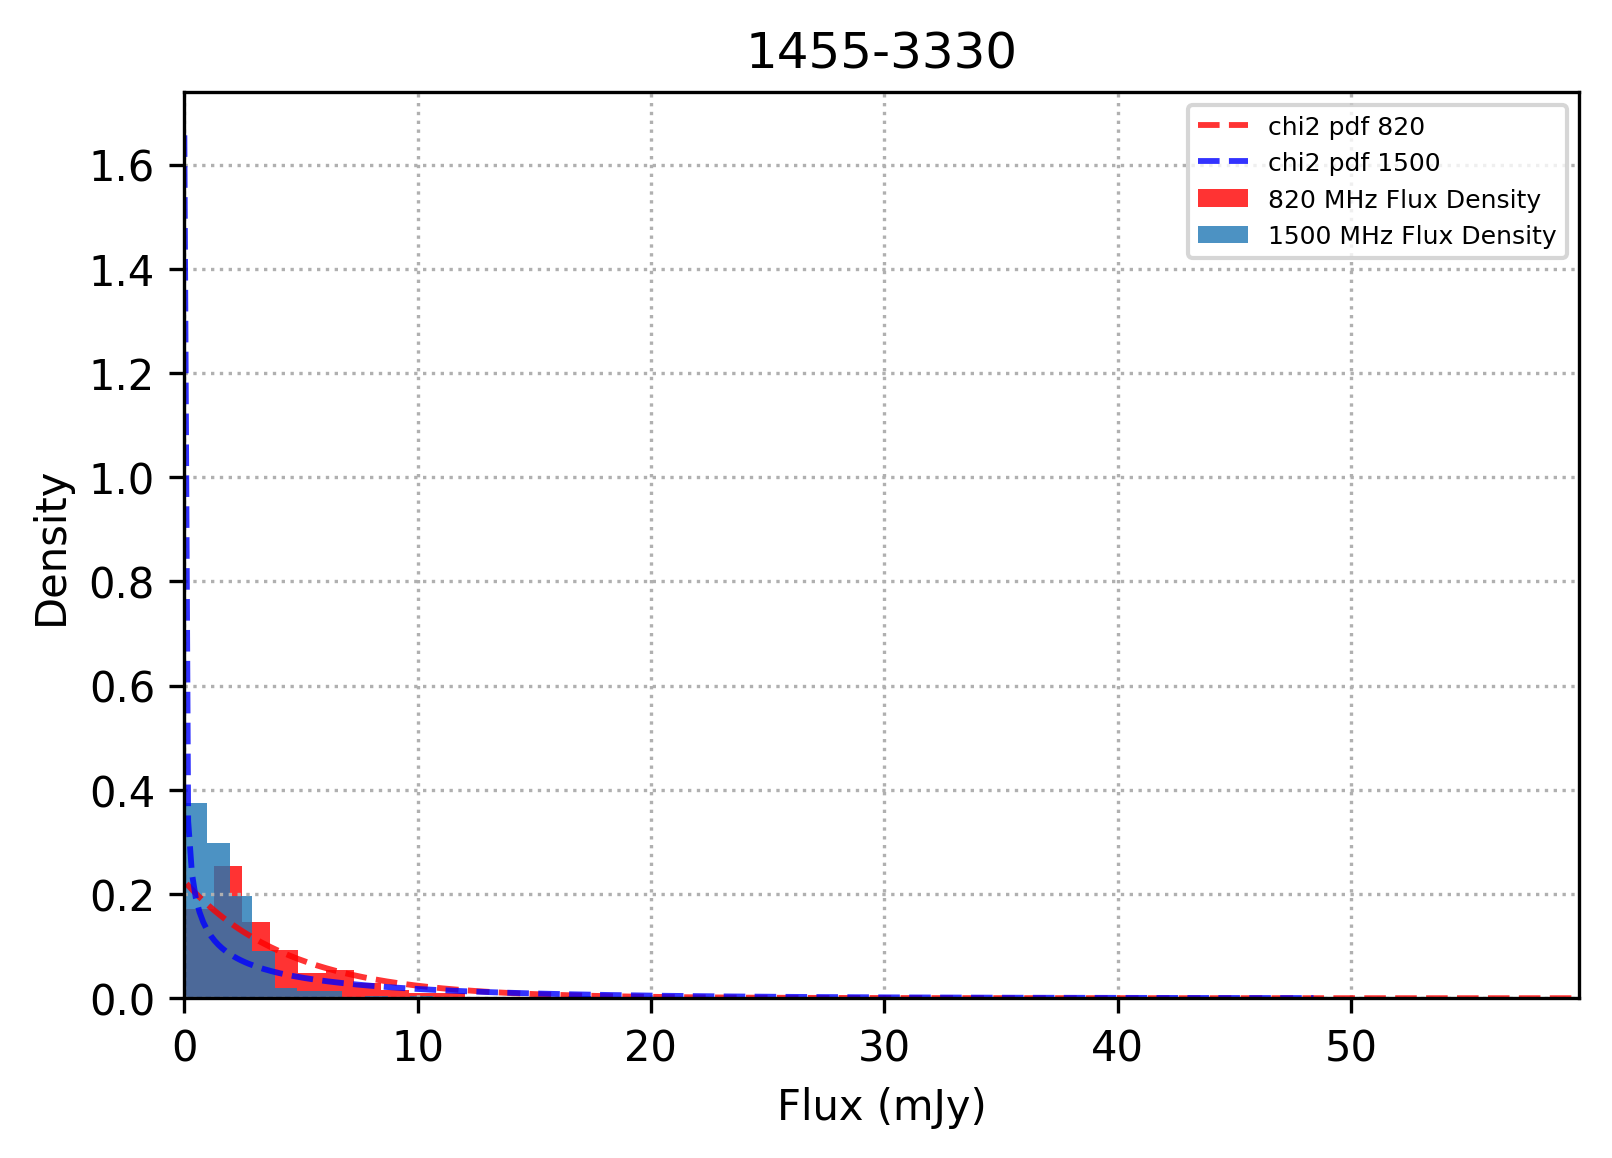

In [9]:
flux_stats('1455-3330',100)

In [20]:
# test_joe_code(pulsar_name,high_limit,wrt=False)

In [16]:
# for x in plsrz:
#     print x
#     try:
#         flux_stats(x,100,scatter=False,hist=False)
#     except:
#         pass

In [15]:
# flux_stats('1918-0642',100,scatter=False,hist=False)

In [1]:
import flux_statistics as fs

Current working directory is: /home/jovyan/work/shared/Flux-Project/data/


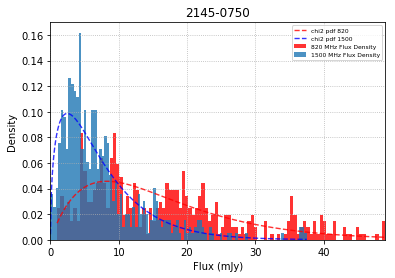

In [28]:
g = 5.0
fs.flux_stats('2145-0750',50,std_a=g,std_b=g,hist=True,scatter=False,stats=False,bins=100)